<a href="https://colab.research.google.com/github/helvete74/IFAGE_dev_AI/blob/main/Efficient_Object_Detection_with_YOLOV8_and_KerasCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TUTO Efficient Object Detection with YOLOV8 and KerasCV

https://keras.io/examples/vision/yolov8/

In [1]:
!pip install roboflow

In [10]:
# download the dataset from roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="4RTem5JDv2kRxw8jk1El")

# version yoloV8
# project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
# version = project.version(3)
# dataset = version.download("yolov8")

#Pascal VOC XML
project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
version = project.version(3)
dataset = version.download("voc")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Self-Driving-Car-3 in voc:: 100%|██████████| 59603/59603 [00:08<00:00, 7378.95it/s]


install KerasCV

In [3]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.3 MB/s eta 0:00:00


Import lib

In [30]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization


Hyperparameters

In [31]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0


A dictionary is created to map each class name to a unique numerical identifier. This mapping is used to encode and decode the class labels during training and inference in object detection tasks.

In [32]:
'''
class_ids = [
    "car",
    "pedestrian",
    "trafficLight",
    "biker",
    "truck",
]
'''
# class_ids from the Udacity Self Driving Car Dataset
class_ids = [
    "car",
    "pedestrian",
    "trafficLight-Red",
    "trafficLight-Green",
    "truck",
    "trafficLight",
    "biker",
    "trafficLight-RedLeft",
    "trafficLight-GreenLeft",
    "trafficLight-Yellow",
    "trafficLight-YellowLeft"
]



class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'car',
 1: 'pedestrian',
 2: 'trafficLight-Red',
 3: 'trafficLight-Green',
 4: 'truck',
 5: 'trafficLight',
 6: 'biker',
 7: 'trafficLight-RedLeft',
 8: 'trafficLight-GreenLeft',
 9: 'trafficLight-Yellow',
 10: 'trafficLight-YellowLeft'}

In [33]:
# Path to images and annotations
# path_images = "/kaggle/input/dataset/data/images/"
# path_annot = "/kaggle/input/dataset/data/annotations/"
# local path :
path_annot = "Self-Driving-Car-3/export"
path_images  = "Self-Driving-Car-3/export"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [ ]:
jpg_files

In [ ]:
xml_files

In [34]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)


  0%|          | 0/29800 [00:00<?, ?it/s]

In [ ]:
classes

In [35]:
# create irregular tensor with tf.ragged
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

# create the dataset
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))


Splitting data in training and validation data

In [36]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)




```
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': tf.Tensor(shape=[batch, num_boxes])
}
```




In [37]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # add resize image
    # image = tf.image.resize(image, (512, 512))
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

Data Augmentation

In [38]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)


In [39]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

Creating Training Dataset

In [40]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
# train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE) # with augmenter
train_ds = train_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE) # with resizing like val_ds

Creating Validation Dataset

In [41]:
'''

resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)
'''
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

Visualization

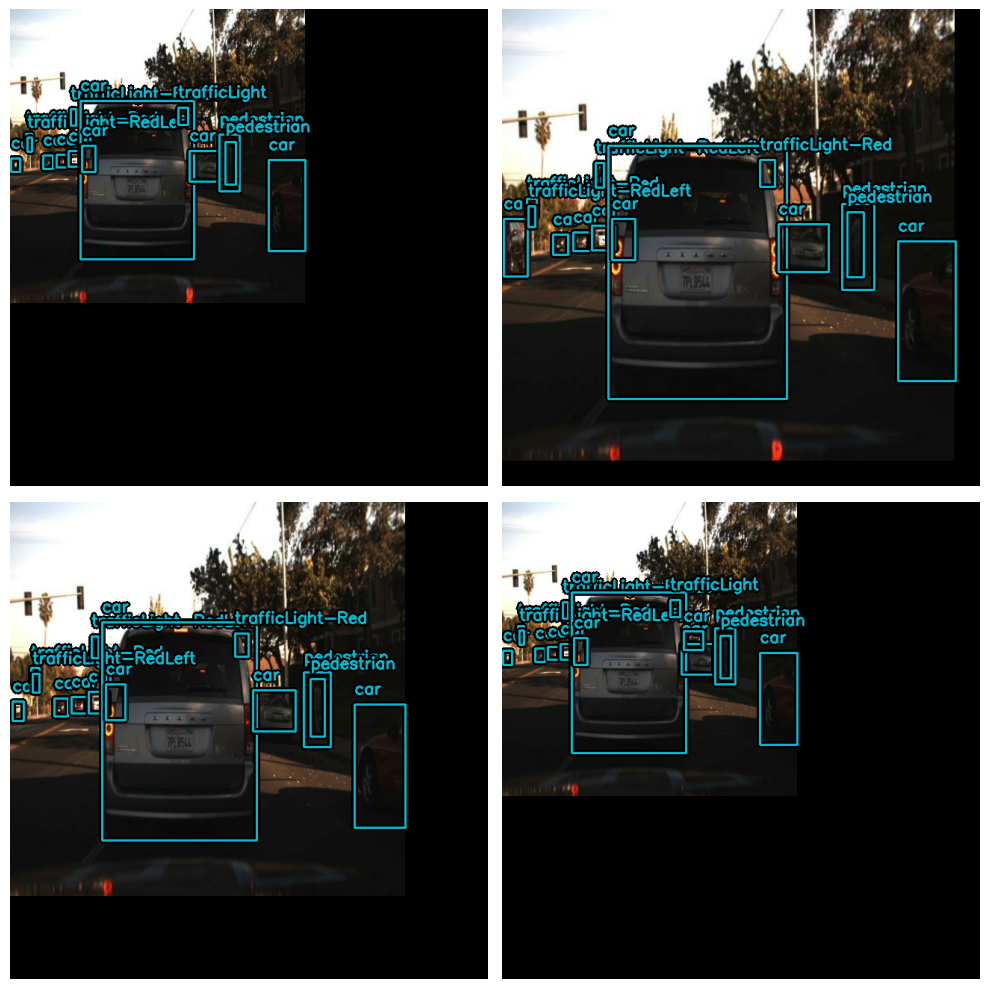

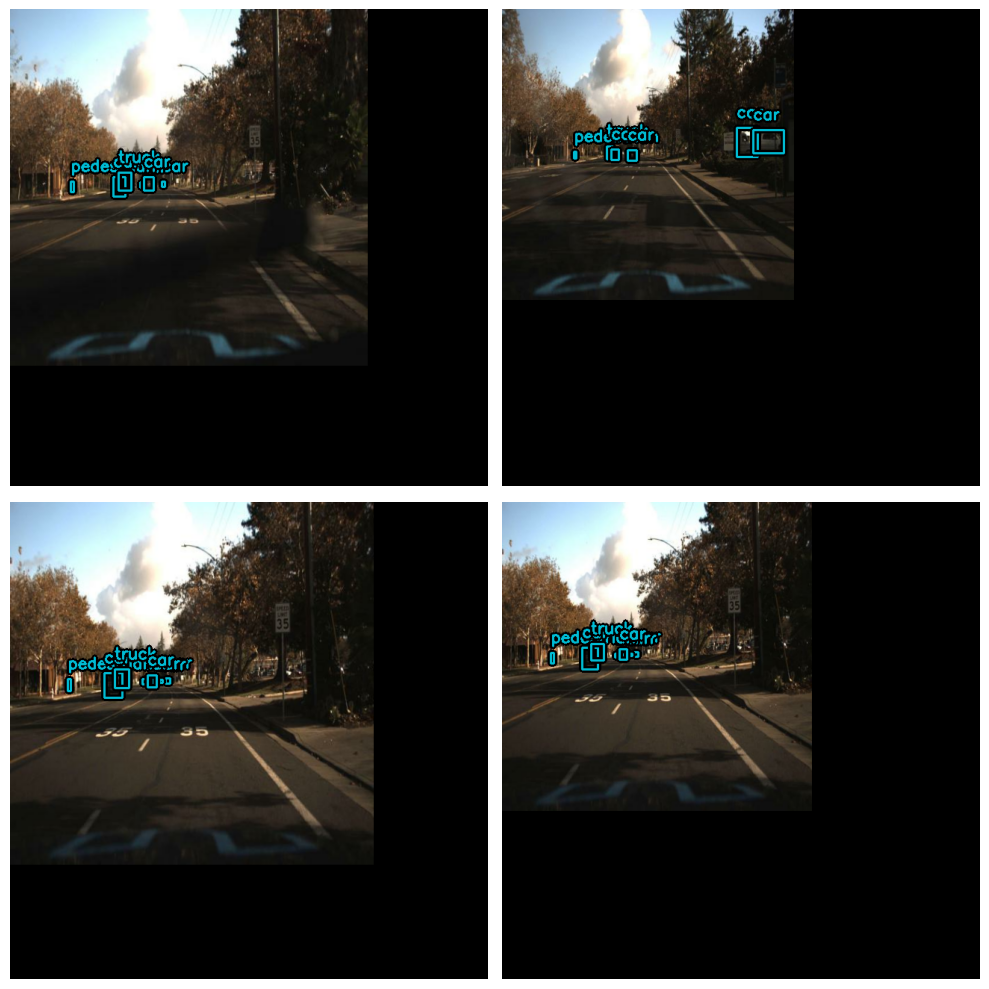

In [42]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

We need to extract the inputs from the preprocessing dictionary and get them ready to be fed into the model.

In [43]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds

Creating Model\
the Yolov8 model : https://blog.roboflow.com/whats-new-in-yolov8/

Avec un model pre-entrainer sur des données COCO

In [44]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


integration de nos paramètres :

In [45]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

Compile the Model

In [46]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

COCO Metric Callback

In [47]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    # surcharge _box_concat pour concatene des tenseurs de differentes formes
    def _box_concat(self, boxes):
        """Concatenate boxes from different tensors."""
        result = {}
        shapes = set()
        for b in boxes:
            shapes.add(tf.shape(b["boxes"])[0])

        if len(shapes) > 1:
            raise ValueError("All boxes must have the same number of instances.")

        for key in boxes[0]:
            result[key] = tf.concat([b[key] for b in boxes], axis=0)

        return result

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


Train the Model

Pronblème:\
error : ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,9,4] vs. shape[2] = [4,6,4]\
Ajout de :\
image = tf.image.resize(image, (512, 512)) #add resize image\
même chose\
je ne sais pas comment ajuster le train_label
>> utilisation de resizing dans le df de train et de validation

relance\
error : ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,5,4] vs. shape[1] = [4,9,4] [Op:ConcatV2]
suggestion :\
The error is caused by a dimension mismatch in the _box_concat function within the BoxCOCOMetrics class. Specifically, the function is attempting to concatenate tensors with different shapes along the first axis.\
modification de COCOMetricsCallback\
Toujours la meme erreur.
:(
  





In [48]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/3
5960/5960 [==============================] - ETA: 0s - loss: 4.2748 - box_loss: 2.2876 - class_loss: 1.9872

UnknownError: {{function_node __wrapped__EagerPyFunc_Tin_1_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_1490_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,6,4] vs. shape[2] = [4,8,4] [Op:ConcatV2] name: concat
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 205, in result_on_host_cpu
    return tf.constant(obj_result(force), obj.dtype)

  File "/usr/local/lib/python3.10/dist-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 256, in result
    self._cached_result = self._compute_result()

  File "/usr/local/lib/python3.10/dist-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 264, in _compute_result
    _box_concat(self.ground_truths),

  File "/usr/local/lib/python3.10/dist-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 44, in _box_concat
    result[key] = tf.concat([b[key] for b in boxes], axis=0)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5883, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_1490_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,6,4] vs. shape[2] = [4,8,4] [Op:ConcatV2] name: concat

 [Op:EagerPyFunc] name: 